In [1]:
from phw_lib import *
import obspy
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
deglitched_data_folder = '/data01/public_data/Deglitched_sols/'
peak_num = 200

In [12]:
res_dict = dict()
for st_file in Path(deglitched_data_folder).glob('*.mseed'):
    key = st_file.name
    res_dict[key] = dict()
    res_dict[key]['freq'] = []
    res_dict[key]['R2'] = []
    res_dict[key]['SS'] =  []
    res_dict[key]['SS_mag'] =  []
    res_dict[key]['CIPSR'] = []

    st = obspy.read(str(st_file))
    # select Z channel
    st_bhz = st.select(channel='??Z')

    # fft transform
    npts = st_bhz[0].stats.npts
    dt = st_bhz[0].stats.delta
    f = np.fft.rfftfreq(npts, dt)

    ori_data = st_bhz[0].data.copy()
    
    Y = np.fft.rfft(ori_data)
    Y_abs = np.abs(Y)**2
    
    # 0.2 mHz to 10 mHz
    min_freq = 2*1e-5
    max_freq = 10*1e-3

    fs = 1/dt
    time_duration = st[0].stats.endtime - st[0].stats.starttime
    n_samples = int(time_duration/dt)
    t = np.arange(0, time_duration, dt)
    freqs = np.fft.fftfreq(len(t), dt)

    search_lower_range = min_freq
    search_upper_range = max_freq

    lower_freq = min_freq
    upper_freq = max_freq

    min_freq_index = np.argmin(np.abs(f - min_freq))
    max_freq_index = np.argmin(np.abs(f - max_freq))

    fft_amp = Y_abs

    peaks, _ = find_peaks(fft_amp, distance=1)

    peaks = peaks[np.logical_and(f[peaks] > search_lower_range, f[peaks] < search_upper_range)]
    peaks = peaks[np.argsort(fft_amp[peaks])][::-1][:peak_num]
    # sort for top 100 peaks
    for t_peak in peaks:
        target_freq = f[t_peak]
        R = calculate_walkout_R2(ori_data, dt, target_freq)
        sum_ratio = linearity_measure_by_sum_ratio(ori_data, dt, target_freq)
        schuster_significance, ss_mag = schuster_test_for_phasor_walkout(ori_data, dt, target_freq)
        res_dict[key]['freq'].append(target_freq)
        res_dict[key]['R2'].append(R)
        res_dict[key]['SS'].append(schuster_significance)
        res_dict[key]['SS_mag'].append(ss_mag)
        res_dict[key]['CIPSR'].append(sum_ratio)
    print('Done processing:', key, 'with', len(peaks), 'peaks found.')

np.save('./deglitched_sols_results.npy', res_dict)

Done processing: Deglitched_sol_1159_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_102_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_583_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_603_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_826_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_1103_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_395_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_927_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_659_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_794_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_224_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_340_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_1160_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_317_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_822_ZNE.mseed

/home/supermicro/anaconda3/envs/tf2_base/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/supermicro/anaconda3/envs/tf2_base/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/supermicro/anaconda3/envs/tf2_base/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Done processing: Deglitched_sol_939_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_136_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_866_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_396_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_1217_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_680_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_190_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_598_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_834_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_131_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_979_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_943_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_1012_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_900_ZNE.mseed with 200 peaks found.
Done processing: Deglitched_sol_409_ZNE.mseed 

In [3]:
res_dict = np.load('./deglitched_sols_results.npy', allow_pickle=True)[()]

In [4]:
# SSmag_dict_larger_than_5
SSmag_dict_larger_than_5 = dict()
total_counter = 0
ss_hit_counter = 0
for key in res_dict.keys():
    if len(res_dict[key]['SS_mag']) > 0:
        for t_dx, t_ssmag in enumerate(res_dict[key]['SS_mag']):
            total_counter += 1
            if t_ssmag > 5:
                ss_hit_counter += 1
                if key not in SSmag_dict_larger_than_5:
                    SSmag_dict_larger_than_5[key] = dict()
                    SSmag_dict_larger_than_5[key]['freq'] = []
                    SSmag_dict_larger_than_5[key]['R2'] = []
                    SSmag_dict_larger_than_5[key]['SS'] = []
                    SSmag_dict_larger_than_5[key]['SS_mag'] = []
                    SSmag_dict_larger_than_5[key]['CIPSR'] = []
                SSmag_dict_larger_than_5[key]['freq'].append(res_dict[key]['freq'][t_dx])
                SSmag_dict_larger_than_5[key]['R2'].append(res_dict[key]['R2'][t_dx])
                SSmag_dict_larger_than_5[key]['SS'].append(res_dict[key]['SS'][t_dx])
                SSmag_dict_larger_than_5[key]['SS_mag'].append(t_ssmag)
                SSmag_dict_larger_than_5[key]['CIPSR'].append(res_dict[key]['CIPSR'][t_dx])

print('Total peaks found:', total_counter)
print('SS magnitude larger than 5:', ss_hit_counter)

Total peaks found: 193200
SS magnitude larger than 5: 75


In [5]:
print('filename,freq,R2,SS,SS_mag,CIPSR')
for key in SSmag_dict_larger_than_5:
    for kdx in range(len(SSmag_dict_larger_than_5[key]['freq'])):
        print('{},{},{},{},{},{}'.format(key, 
                                         SSmag_dict_larger_than_5[key]['freq'][kdx],
                                         SSmag_dict_larger_than_5[key]['R2'][kdx],
                                         SSmag_dict_larger_than_5[key]['SS'][kdx],
                                         SSmag_dict_larger_than_5[key]['SS_mag'][kdx],
                                         SSmag_dict_larger_than_5[key]['CIPSR'][kdx]))                                                                                  

filename,freq,R2,SS,SS_mag,CIPSR
Deglitched_sol_603_ZNE.mseed,0.0008726003490401395,0.8307224934333904,0.9999999895772966,7.982019620838269,0.6358410811853613
Deglitched_sol_1021_ZNE.mseed,0.0009027777777777777,0.7257787061496839,0.9999982537446651,5.757892254078423,0.4138890877256032
Deglitched_sol_390_ZNE.mseed,0.0010119047619047618,0.8911527275739543,0.9999992339704904,6.115754499784281,0.5525495639732547
Deglitched_sol_981_ZNE.mseed,0.0008333333333333333,0.621214051378429,0.9999989555541685,5.98111407910537,0.5634325942440643
Deglitched_sol_420_ZNE.mseed,0.0008432539682539683,0.9650227783136397,0.9999999797934327,7.69450745844914,0.5962144317442174
Deglitched_sol_719_ZNE.mseed,0.0008919914679076982,0.27374498247464685,0.9999917862512903,5.085458588021448,0.4612509189743583
Deglitched_sol_451_ZNE.mseed,0.0008035714285714286,0.7033274736191479,0.999996706519782,5.4823449407602265,0.4951910833410253
Deglitched_sol_476_ZNE.mseed,0.0009424603174603175,0.8860678615146161,0.99999693341733

In [6]:
# top ten SS mag
top_ten_ss_mag = []
for key in SSmag_dict_larger_than_5.keys():
    for t_dx, t_ssmag in enumerate(SSmag_dict_larger_than_5[key]['SS_mag']):
        top_ten_ss_mag.append((key, SSmag_dict_larger_than_5[key]['freq'][t_dx], t_ssmag))
top_ten_ss_mag = sorted(top_ten_ss_mag, key=lambda x: x[2], reverse=True)[:10]

In [7]:
lower_freq = 0.2*1e-3
upper_freq = 10.0*1e-3

In [8]:
import pandas as pd

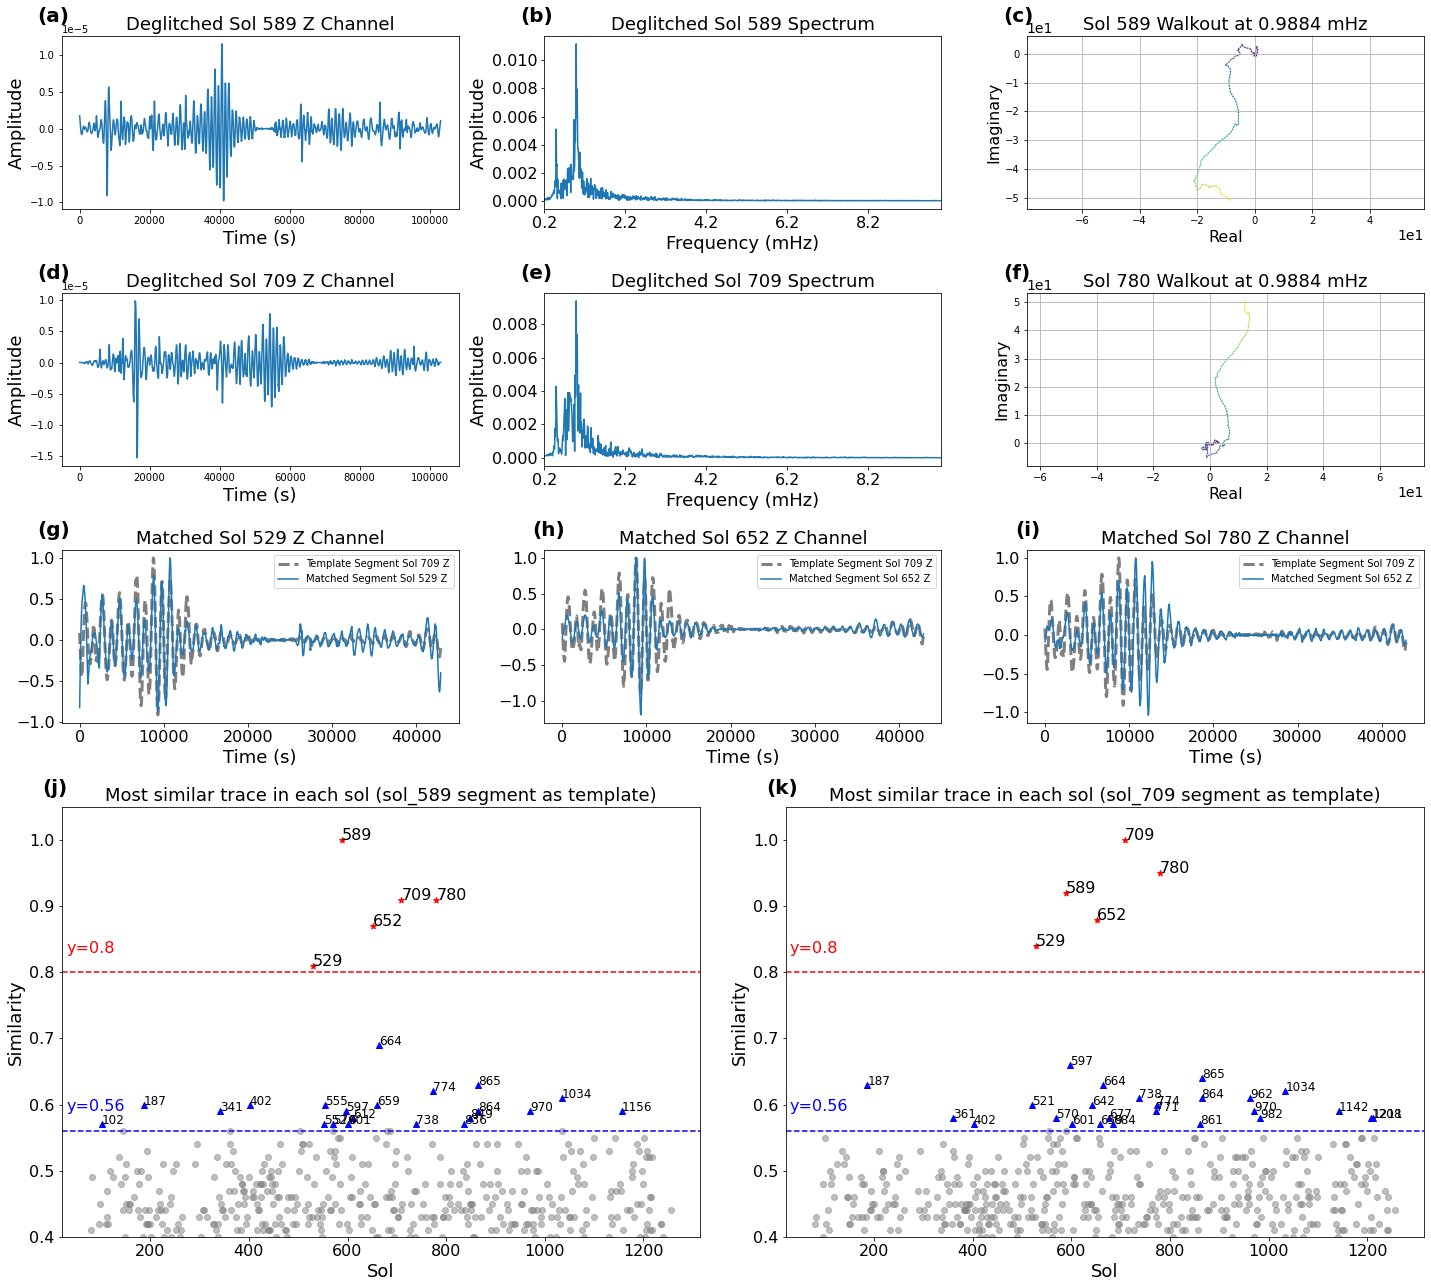

In [9]:
# vis 589 and 709
# Please download the deglitched data from 
mseed_589 = obspy.read('./Deglitched_sol_589_ZNE.mseed')
mseed_709 = obspy.read('./Deglitched_sol_709_ZNE.mseed')

mseed_589_Z = mseed_589.select(channel='??Z')[0]
mseed_709_Z = mseed_709.select(channel='??Z')[0]

plt.figure(figsize=(20, 18))
#plt.subplot(2, 3, 1)
ax1 = plt.subplot2grid((5, 6), (0, 0), colspan=2)
plt.text(-0.06, 1.08, '(a)', transform=plt.gca().transAxes, size=20, weight='bold')
plt.plot(mseed_589_Z.times(), mseed_589_Z.data, label='Deglitched Sol 589 Z')
plt.title('Deglitched Sol 589 Z Channel', fontsize=18)
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
#plt.grid()
#plt.subplot(2, 3, 2)
ax2 = plt.subplot2grid((5, 6), (0, 2), colspan=2)
plt.text(-0.06, 1.08, '(b)', transform=plt.gca().transAxes, size=20, weight='bold')

fs = mseed_589_Z.stats.sampling_rate
dt = 1/fs
time_duration = mseed_589_Z.stats.endtime - mseed_589_Z.stats.starttime
n_samples = int(time_duration/dt)
t = np.arange(0, time_duration, dt)
freqs = np.fft.fftfreq(len(t), dt)
spectrum_amp = np.abs(np.fft.fft(mseed_589_Z.data))[:int(len(freqs)/2)]
plt.plot(freqs[:int(len(freqs)/2)], spectrum_amp[:int(len(freqs)/2)])
plt.xlim([lower_freq, upper_freq])
plt.xlabel('Frequency (mHz)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
# set the xticks in {:.2f} mHz format
plt.xticks(np.arange(lower_freq, upper_freq, 2*1e-3), 
              ['{:.1f}'.format(freq*1e3) for freq in np.arange(lower_freq, upper_freq, 2*1e-3)], fontsize=16)
plt.yticks(fontsize=16)
# add (b) to the subplot
plt.title('Deglitched Sol 589 Spectrum', fontsize=18)

ax3 = plt.subplot2grid((5, 6), (0, 4), colspan=2)
plt.text(-0.06, 1.08, '(c)', transform=plt.gca().transAxes, size=20, weight='bold')
t_freq = 0.000988372093023256
visualize_walkout_for_subplot_sum_with_period(mseed_589_Z.data, dt, t_freq)
plt.title('Sol 589 Walkout at {:.4f} mHz'.format(t_freq*1e3), fontsize=18)

ax4 = plt.subplot2grid((5, 6), (1, 0), colspan=2)
plt.text(-0.06, 1.08, '(d)', transform=plt.gca().transAxes, size=20, weight='bold')
plt.plot(mseed_709_Z.times(), mseed_709_Z.data, label='Deglitched Sol 709 Z')
plt.title('Deglitched Sol 709 Z Channel', fontsize=18)
plt.xlabel('Time (s)',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
#plt.grid()

ax5 = plt.subplot2grid((5, 6), (1, 2), colspan=2)
plt.text(-0.06, 1.08, '(e)', transform=plt.gca().transAxes, size=20, weight='bold')
fs = mseed_709_Z.stats.sampling_rate
dt = 1/fs
time_duration = mseed_709_Z.stats.endtime - mseed_709_Z.stats.starttime
n_samples = int(time_duration/dt)
t = np.arange(0, time_duration, dt)
freqs = np.fft.fftfreq(len(t), dt)
spectrum_amp = np.abs(np.fft.fft(mseed_709_Z.data))[:int(len(freqs)/2)]
plt.plot(freqs[:int(len(freqs)/2)], spectrum_amp[:int(len(freqs)/2)])
plt.xlim([lower_freq, upper_freq])
plt.xlabel('Frequency (mHz)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
# set the xticks in {:.2f} mHz format
plt.xticks(np.arange(lower_freq, upper_freq, 2*1e-3), 
              ['{:.1f}'.format(freq*1e3) for freq in np.arange(lower_freq, upper_freq, 2*1e-3)], fontsize=16)
#plt.yticks(np.arange(np.min(spectrum_amp), np.max(spectrum_amp), (np.max(spectrum_amp)-np.min(spectrum_amp))/5), fontsize=16)
plt.yticks(fontsize=16)
# add (e) to the subplot
plt.title('Deglitched Sol 709 Spectrum', fontsize=18)

ax6 = plt.subplot2grid((5, 6), (1, 4), colspan=2)
plt.text(-0.06, 1.08, '(f)', transform=plt.gca().transAxes, size=20, weight='bold')
t_freq = 0.000988372093023256
visualize_walkout_for_subplot_sum_with_period(mseed_709_Z.data, dt, t_freq)
plt.title('Sol 780 Walkout at {:.4f} mHz'.format(t_freq*1e3), fontsize=18)
plt.tight_layout()

Sol_529_trace = obspy.read('./Deglitched_sol_529_ZNE.mseed').select(channel='??Z')[0].slice(starttime=obspy.UTCDateTime('2020-05-23T03:44:10'), endtime = obspy.UTCDateTime('2020-05-23T15:38:50'))
Sol_652_trace = obspy.read('./Deglitched_sol_652_ZNE.mseed').select(channel='??Z')[0].slice(starttime=obspy.UTCDateTime('2020-09-26T13:59:40'), endtime = obspy.UTCDateTime('2020-09-27T01:54:20'))
Sol_780_trace = obspy.read('./Deglitched_sol_780_ZNE.mseed').select(channel='??Z')[0].slice(starttime=obspy.UTCDateTime('2021-02-05T02:00:35'), endtime = obspy.UTCDateTime('2021-02-05T13:55:15'))

sol_709_template = np.load('./sol_709_full.npy')

sol_709_template -= np.mean(sol_709_template)
sol_709_template /= np.max(np.abs(sol_709_template))

Sol_529_trace.data[:] -= np.mean(Sol_529_trace.data[:])
Sol_529_trace.data[:] /= np.max(Sol_529_trace.data[:])

Sol_652_trace.data[:] -= np.mean(Sol_652_trace.data[:])
Sol_652_trace.data[:] /= np.max(Sol_652_trace.data[:])

Sol_780_trace.data[:] -= np.mean(Sol_780_trace.data[:])
Sol_780_trace.data[:] /= np.max(Sol_780_trace.data[:])

ax7 = plt.subplot2grid((5, 6), (2, 0), colspan=2)
plt.text(-0.06, 1.08, '(g)', transform=plt.gca().transAxes, size=20, weight='bold')
#plt.plot(Sol_529_trace.times(), sol_589_template, label='Deglitched Sol 589 Z', color = 'gray', linestyle='--', alpha=0.5)
plt.plot(Sol_529_trace.times()[:len(sol_709_template)], sol_709_template, label='Template Segment Sol 709 Z', color = 'k', linestyle='--', alpha=0.5, linewidth=3)
plt.plot(Sol_529_trace.times(), Sol_529_trace.data, label='Matched Segment Sol 529 Z')
plt.legend()
plt.xlabel('Time (s)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Matched Sol 529 Z Channel', fontsize=18)

ax8 = plt.subplot2grid((5, 6), (2, 2), colspan=2)
plt.text( -0.03, 1.08, '(h)', transform=plt.gca().transAxes, size=20, weight='bold')
plt.plot(Sol_529_trace.times()[:len(sol_709_template)], sol_709_template, label='Template Segment Sol 709 Z', color = 'k', linestyle='--', alpha=0.5, linewidth=3)
plt.plot(Sol_652_trace.times(), Sol_652_trace.data, label='Matched Segment Sol 652 Z')
plt.title('Matched Sol 652 Z Channel', fontsize=18)
plt.xlabel('Time (s)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

ax9 = plt.subplot2grid((5, 6), (2, 4), colspan=2)
plt.text( -0.03, 1.08, '(i)', transform=plt.gca().transAxes, size=20, weight='bold')
plt.plot(Sol_529_trace.times()[:len(sol_709_template)], sol_709_template, label='Template Segment Sol 709 Z', color = 'k', linestyle='--', alpha=0.5, linewidth=3)
plt.plot(Sol_780_trace.times(), Sol_780_trace.data, label='Matched Segment Sol 652 Z')
plt.title('Matched Sol 780 Z Channel', fontsize=18)
plt.xlabel('Time (s)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

ax10 = plt.subplot2grid((5, 6), (3, 0), colspan=3, rowspan=2)
plt.text(-0.03, 1.03, '(j)', transform=plt.gca().transAxes, size=20, weight='bold')
sim_bar_1 = 0.800
sim_bar_2 = 0.560

csv_file = pd.read_csv('./sol_589_matching_segments_info.csv')
sol_dict = {}
for i in range(0, len(csv_file)):
    trace_id = csv_file['Trace ID'][i]
    sol = trace_id.split('_')[2]
    if sol not in sol_dict:
        sol_dict[sol] = []
    else:
        pass
    abs_similar = np.abs(csv_file['Similarity'][i])
    start = csv_file['Start time'][i]
    end = csv_file['End time'][i]

    if len(sol_dict[sol]) == 0:
        sol_dict[sol] = [trace_id, abs_similar, start, end]
    else:
        if abs_similar > sol_dict[sol][1]:
            sol_dict[sol] = [trace_id, abs_similar, start, end]
        else:
            pass

for key in sol_dict.keys():
    sol = int(key)
    abs_similar = sol_dict[key][1]
    if abs_similar > sim_bar_1:
        plt.scatter(sol, abs_similar, color='red', marker='*')
        plt.text(sol, abs_similar, str(sol), fontsize=16)
    elif abs_similar > sim_bar_2:
        plt.scatter(sol, abs_similar, color='blue', marker='^')
        plt.text(sol, abs_similar, str(sol), fontsize=12)
    else:
        plt.scatter(sol, abs_similar, color='gray', marker='o', alpha=0.5)
plt.axhline(y=sim_bar_1, color='r', linestyle='--')
plt.text(30, sim_bar_1 + 0.03 , 'y={}'.format(sim_bar_1), fontsize=16,color='r')
plt.axhline(y=sim_bar_2, color='b', linestyle='--')
plt.text(30, sim_bar_2 + 0.03, 'y={}'.format(sim_bar_2), fontsize=16,color='b')
plt.xlabel('Sol', fontsize=18)
plt.ylabel('Similarity', fontsize=18)
plt.title('Most similar trace in each sol (sol_589 segment as template)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.40, 1.05)



ax11 = plt.subplot2grid((5, 6), (3, 3), colspan=3, rowspan=2)
plt.text(-0.03, 1.03, '(k)', transform=plt.gca().transAxes, size=20, weight='bold')
sim_bar_1 = 0.800
sim_bar_2 = 0.560

csv_file = pd.read_csv('./sol_709_matching_segments_info.csv')

sol_dict = {}
for i in range(0, len(csv_file)):
    trace_id = csv_file['Trace ID'][i]
    sol = trace_id.split('_')[2]
    if sol not in sol_dict:
        sol_dict[sol] = []
    else:
        pass
    abs_similar = np.abs(csv_file['Similarity'][i])
    start = csv_file['Start time'][i]
    end = csv_file['End time'][i]

    if len(sol_dict[sol]) == 0:
        sol_dict[sol] = [trace_id, abs_similar, start, end]
    else:
        if abs_similar > sol_dict[sol][1]:
            sol_dict[sol] = [trace_id, abs_similar, start, end]
        else:
            pass

for key in sol_dict.keys():
    sol = int(key)
    abs_similar = sol_dict[key][1]
    if abs_similar > sim_bar_1:
        plt.scatter(sol, abs_similar, color='red', marker='*')
        plt.text(sol, abs_similar, str(sol), fontsize=16)
    elif abs_similar > sim_bar_2:
        plt.scatter(sol, abs_similar, color='blue', marker='^')
        plt.text(sol, abs_similar, str(sol), fontsize=12)
    else:
        plt.scatter(sol, abs_similar, color='gray', marker='o', alpha=0.5)

plt.axhline(y=sim_bar_1, color='r', linestyle='--')
plt.text(30, sim_bar_1 + 0.03 , 'y={}'.format(sim_bar_1), fontsize=16,color='r')
plt.axhline(y=sim_bar_2, color='b', linestyle='--')
plt.text(30, sim_bar_2 + 0.03, 'y={}'.format(sim_bar_2), fontsize=16,color='b')
plt.xlabel('Sol', fontsize=18)
plt.ylabel('Similarity', fontsize=18)
plt.title('Most similar trace in each sol (sol_709 segment as template)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.40, 1.05)

plt.tight_layout()
plt.savefig('Figure_11.jpg', dpi=500)
plt.show()
plt.close()